# inspect llc parcel simulation

In [1]:
import os, shutil
import glob

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import geopandas

import dask
from dask.delayed import delayed
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import xgcm

from parcels import FieldSet, ParticleSet, ParticleFile, plotTrajectoriesFile
#from parcels import FieldSet, ParticleFile, plotTrajectoriesFile
#from mitequinox.particleset import ParticleSet
from parcels import JITParticle, ScipyParticle
from parcels import ErrorCode, NestedField, AdvectionEE, AdvectionRK4

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#cluster = LocalCluster(processes=False, n_workers=4, threads_per_worker=2)
#
from dask_jobqueue import PBSCluster
# ** processes and cores may be adjusted in order to have more memory or inversely more computational ressource
#cluster = PBSCluster(processes=5, cores=5, walltime='04:00:00')
#cluster = PBSCluster(walltime='04:00:00')
cluster = PBSCluster()
w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.59:43748 Dashboard: http://10.148.0.59:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## setup directories and run parameters

In [3]:
#root_dir = ut.root_data_dir+'parcels/'
root_dir = '/home1/scratch/aponte/parcels/'
#root_dir = '/home1/dunree/slgentil/tmp/parcels/'

run_name = "test1"
#run_name = 'test2'
#run_name = 'test3'
#run_name = 'test4'

run_dir = root_dir+run_name

In [4]:
# not working pickle issue

#tile_dir = os.path.join(run_dir,'tiling/')

#tl = pa.tiler(tile_dir=tile_dir)    
#tile_data_dirs = [os.path.join(run_dir,'data_{:03d}'.format(t)) 
#                  for t in range(tl.N_tiles)
#                 ]

In [5]:
# simulation parameters

#T = 360? # length of the total run [days]
T = 20 # ** debug
#dt_windows = 5 # time window
dt_windows = 2 # ** debug, 5j devrait être plus approprié je pense
dt_stepping = 1 # hours
dt_outputs = 1 # hours

dij_init = 10 # initial position subsampling compared to llc grid

---

## load llc data

In [6]:
%%time
if False:
    # load llc data
    ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
    grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
    ds = xr.merge([ds, grd])
    ds

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


---

## create tiles - !!! should be deleted eventually

This could be done somewhere else, in another notebook

See `rearrange.ipynb` and `tile.ipynb` for more details

** Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant

In [7]:
# simulation parameters
dij_init = 10 # initial position subsampling compared to llc grid

In [8]:
%%time

create_tiles = False

tile_dir = os.path.join(run_dir,'tiling/')
#tile_dir = '/home1/scratch/aponte/parcels/tile_tmp/'
if create_tiles:
    
    # ** could filter out tiles that are empty, criterium on Depth or SST should be sufficient

    # create tiler
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(10, 10), overlap=(100, 100))
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 20), overlap=(100, 100))
    tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 5), overlap=(100, 100))
    # store tiler
    tl.store(tile_dir)
    
else:
    
    #tile_dir = ut.root_data_dir+'parcels/tiling/'
    #tile_dir = os.path.join(run_dir,'tiling/')
    tl = pa.tiler(tile_dir=tile_dir)
    
tile_data_dirs = [os.path.join(run_dir,'data_{:03d}'.format(t)) 
                  for t in range(tl.N_tiles)
                 ]

CPU times: user 436 ms, sys: 24 ms, total: 460 ms
Wall time: 456 ms


In [9]:
#print(tl.global_domain_size)
for tile in range(tl.N_tiles):
    print('boundaries=',tile, tl.boundaries[tile])

boundaries= 0 (slice(125, 3581, None), slice(0, 2667, None))
boundaries= 1 (slice(125, 3581, None), slice(2667, 5209, None))
boundaries= 2 (slice(125, 3581, None), slice(5209, 7751, None))
boundaries= 3 (slice(125, 3581, None), slice(7751, 10293, None))
boundaries= 4 (slice(125, 3581, None), slice(10293, 12960, None))
boundaries= 5 (slice(3581, 7037, None), slice(0, 2667, None))
boundaries= 6 (slice(3581, 7037, None), slice(2667, 5209, None))
boundaries= 7 (slice(3581, 7037, None), slice(5209, 7751, None))
boundaries= 8 (slice(3581, 7037, None), slice(7751, 10293, None))
boundaries= 9 (slice(3581, 7037, None), slice(10293, 12960, None))
boundaries= 10 (slice(7037, 10493, None), slice(0, 2667, None))
boundaries= 11 (slice(7037, 10493, None), slice(2667, 5209, None))
boundaries= 12 (slice(7037, 10493, None), slice(5209, 7751, None))
boundaries= 13 (slice(7037, 10493, None), slice(7751, 10293, None))
boundaries= 14 (slice(7037, 10493, None), slice(10293, 12960, None))
boundaries= 15 (slic

---
## load dataset and plot a subset of trajectories

In [10]:
float_files = []
for _dir in tile_data_dirs:
    float_files.extend(sorted(glob.glob(_dir+"/floats_*.nc")))
    #float_files.extend(sorted(glob.glob(_dir+"/floats_364*.nc")))
print(float_files[:5])
print(float_files[-5:])

['/home1/scratch/aponte/parcels/test1/data_001/floats_000_001.nc', '/home1/scratch/aponte/parcels/test1/data_001/floats_001_001.nc', '/home1/scratch/aponte/parcels/test1/data_001/floats_002_001.nc', '/home1/scratch/aponte/parcels/test1/data_001/floats_003_001.nc', '/home1/scratch/aponte/parcels/test1/data_001/floats_004_001.nc']
['/home1/scratch/aponte/parcels/test1/data_024/floats_360_024.nc', '/home1/scratch/aponte/parcels/test1/data_024/floats_361_024.nc', '/home1/scratch/aponte/parcels/test1/data_024/floats_362_024.nc', '/home1/scratch/aponte/parcels/test1/data_024/floats_363_024.nc', '/home1/scratch/aponte/parcels/test1/data_024/floats_364_024.nc']


In [11]:
def xr2df(file):
    return xr.open_dataset(file).to_dataframe().set_index('trajectory')

lazy_dataframes = [delayed(xr2df)(f) for f in float_files]

In [12]:
_df = lazy_dataframes[0].compute()

In [13]:
df = dd.from_delayed(lazy_dataframes, meta=lazy_dataframes[0].compute())

In [14]:
df_pd = df.compute() # load in notebook, dangerous !!
#df_pd['time']

In [15]:
print(df_pd['time'].min())
print(df_pd['time'].max())

2011-11-15 00:00:00
2012-11-14 01:00:00


## Find lost trajectories

In [16]:
df_gb = df_pd.groupby([df_pd.index])
df_ct = df_gb.count()
df_ct

,time,lat,lon,z
trajectory,,,,
1000000.0,728,728,728,728
1000001.0,650,650,650,650
1000002.0,624,624,624,624
1000003.0,520,520,520,520
1000004.0,390,390,390,390
...,...,...,...,...
24000346.0,1123,1123,1123,1123
24000347.0,930,930,930,930
24000348.0,908,908,908,908


In [17]:
nbtimes = df_ct['time'].max()
print(nbtimes)
dlost = df_ct[df_ct['time'] != nbtimes].index
#dlost = df_ct[df_ct['time'] < 27].index
print(f'Nombre de flotteurs perdus: {dlost.size:5d} ({dlost.size/len(df_ct.index):%})')
dlost

9490
Nombre de flotteurs perdus:  4166 (34.829864%)


Float64Index([ 1000000.0,  1000001.0,  1000002.0,  1000003.0,  1000004.0,
               1000005.0,  1000006.0,  1000011.0,  1000015.0,  1000016.0,
              ...
              24000341.0, 24000342.0, 24000343.0, 24000344.0, 24000345.0,
              24000346.0, 24000347.0, 24000348.0, 24000349.0, 24000350.0],
             dtype='float64', name='trajectory', length=4166)

## Plot last position of lost floats

In [18]:
_d = df_pd[df_pd.index.isin(dlost)]
_d = _d.groupby('trajectory').last()
print(_d)
gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

                          time        lat        lon    z
trajectory                                               
1000000.0  2011-12-13 01:00:00 -71.282973 -35.475074  0.0
1000001.0  2011-12-10 01:00:00 -70.131391 -35.420565  0.0
1000002.0  2011-12-09 01:00:00 -69.415569 -35.513495  0.0
1000003.0  2011-12-05 01:00:00 -68.720438 -35.448262  0.0
1000004.0  2011-11-30 01:00:00 -67.930918 -35.418585  0.0
...                        ...        ...        ...  ...
24000346.0 2011-12-28 03:00:00  59.839938 -38.010286  0.0
24000347.0 2011-12-20 18:00:00  58.528762 -38.010380  0.0
24000348.0 2011-12-19 22:00:00  58.610273 -38.010375  0.0
24000349.0 2011-12-31 01:00:00  58.949735 -38.010357  0.0
24000350.0 2011-12-11 01:00:00  60.750965 -42.802737  0.0

[4166 rows x 4 columns]


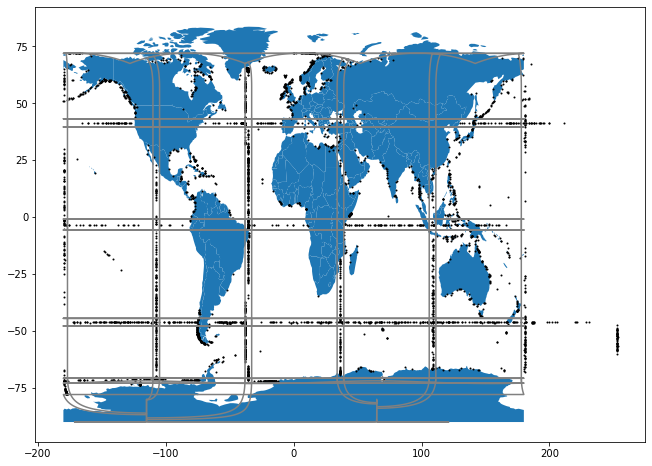

In [19]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs = tl.crs_wgs84

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='k', markersize=1)
#ax.set_axis_off()
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color='0.5')

### plot last time

In [20]:
_d = df_pd[df_pd['time']==df_pd['time'].max()]
gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

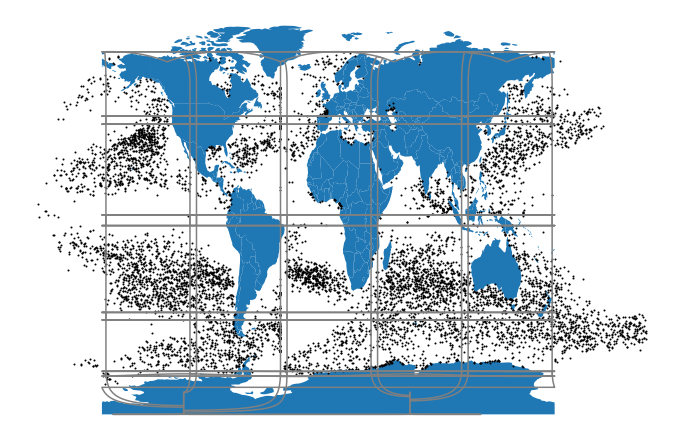

In [21]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs = tl.crs_wgs84

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='k', markersize=1)
ax.set_axis_off()
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color='0.5')

## Plot uncomplete trajectory

In [ ]:
_d = df_pd[df_pd.index.isin(dlost)]
_d = _d.groupby('trajectory')
keys = list(_d.groups.keys())[::10]
_d = _d.filter(lambda x: x.name in keys)
gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs = tl.crs_wgs84

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='r', markersize=1)
#ax.set_axis_off()
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color='0.5')

## Plot a complete trajectory

In [ ]:
_dg = df_pd[~df_pd.index.isin(dlost)].groupby('trajectory')

In [ ]:
keys = list(_dg.groups.keys())[::100]
_d = _dg.filter(lambda x: x.name in keys)

gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs = tl.crs_wgs84

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='r', markersize=0.5)
#ax.set_axis_off()
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color='0.5')

## Close cluster

In [ ]:
cluster.close()